In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from IPython.display import Image, HTML

%matplotlib inline

#  NN II -- Compute Graph, Backprop and Training

In this lecture we'll gradually build out a light weight neural network training framework reminiscent of PyTorch.

We build:
* A simple neural network engine we call `Value` class that wraps numbers and math operators and includes useful attributes and methods for implementing _forward pass_ and _back propagation_. _(~63 lines of code)_

We'll provide (and explain)
* A simple _compute graph_ visualization function. _(34 lines of code)_
* A small set of helper functions that easily define a neuron, layer and multi-layer perceptron (MLP). _(84 lines of code)_

With that we can implement a neural network training loop, and see how similar it is to a PyTorch implementation.

---
The code is based on Andrej Karpathy's [micrograd](https://github.com/karpathy/micrograd).

## Neuron and Neural Networks (Recap)

Now let's switch gears a bit to define an _artificial neuron_. For better or worse
it is named after and loosely modeled on a biological neuron.


<!-- Image Credit "https://cs231n.github.io/neural-networks-1/"-->

<center>
    
<img src="figs/NN-figs/neuron.png" width="75%">
    
</center> 

From [cs231n](https://cs231n.github.io/neural-networks-1/)

* The dendrites carry impulses from other neurons of different distances.
* Once the collective firing rate of the impulses exceed a certain threshold, the neuron fires its own pulse through the axon to other neurons

There are companies trying to mimic this impulse (i.e. spiking) based neuron in silicon -- so called _neuromorphic computing_.

See for example [Neuromorphic Computing](https://en.wikipedia.org/wiki/Neuromorphic_engineering) or [Spiking Neural Network](https://en.wikipedia.org/wiki/Spiking_neural_network)

Some examples of companies and projects are Intel's [Loihi](https://www.intel.com/content/www/us/en/research/neuromorphic-computing-loihi-2-technology-brief.html) and startups such as GrAI Matter Labs [VIP processor](https://www.graimatterlabs.ai/product).

### Artificial Neuron

<!-- Image Credit "https://cs231n.github.io/neural-networks-1/"-->

<center>
    
<img src="figs/NN-figs/neuron_model.jpeg" width="75%">
    
</center> 

From [cs231n](https://cs231n.github.io/neural-networks-1/)

The more common artifical neuron 
* collects one or more inputs, 
* each multiplied by a unique weight
* sums the weighted inputs
* adds a bias
* then finally usually applies a nonlinear activation function

### Relating Back to Earlier Lectures

__Question__

What does 

$$\sum_i w_i x_i + b$$

remind you of?

__Answer__

How about multiple regression in the Linear Regression lecture?

$$y = \beta_0 + \beta_1 u + \beta_2 v$$

We just renamed things: $\beta_0 \gets b$, $\beta_1 \gets w_0$, $\beta_2 \gets w_1$, $u \gets x_0$ and $v \gets x_1$ for $i \in [0,1]$.

> So multiple linear regression can be viewed as one linear neuron.

Activation function is typically some nonlinear function that compresses the input in some way. Historically, it's been the sigmoid and $\tanh()$ functions. See for example [Hyperbolic Functions](https://en.wikipedia.org/wiki/Hyperbolic_functions#Tanh).

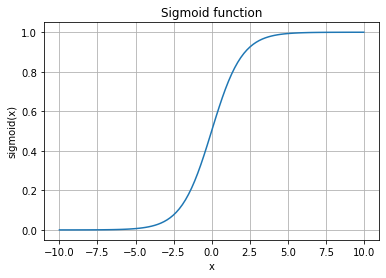

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-10, 10, 100)
y = sigmoid(x)

plt.plot(x, y)
plt.title('Sigmoid function')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.grid(True)
plt.show()

The hyperbolic tangent, $\tanh$, is basically the sigmoid function shifted and scaled to a range of [-1,1].

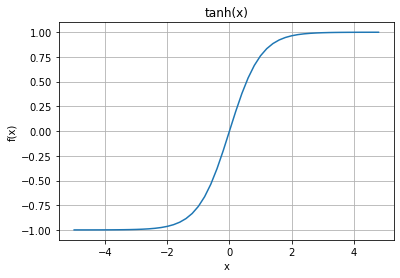

In [9]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.title('tanh(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()

A more common activation function these days and that is more efficient to implement is the _Rectified Linear Unit_ or _ReLU_.

$$ \textrm{ReLU}(x) = \mathrm{max}(0, x) $$

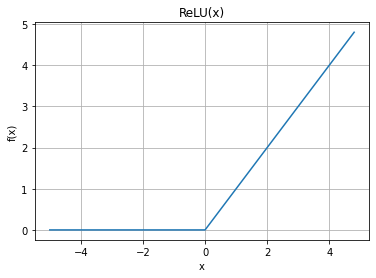

In [10]:
plt.plot(np.arange(-5,5,0.2), np.maximum(0,np.arange(-5,5,0.2)))
plt.title('ReLU(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()

There are many other variations. See for example [PyTorch Non-linear Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

### Relating Back to _Another_ Earlier Lecture

__Question__

What does 

$$ \mathrm{sigmoid}(\sum_i w_i x_i + b) \hspace{10pt} \textrm{where} \hspace{10pt} \mathrm{sigmoid}(x) = \frac{1}{1 + e^{-x}}$$

remind you of?

__Answer__

How about the Logistic Regression model?

$$
\begin{split}
P(y=1\mid x) & = \frac{e^{\alpha+\beta x}}{1+e^{\alpha+\beta x}}\\
             & = \frac{e^{\alpha+\beta x}}{1+e^{\alpha+\beta x}} \left( \frac{e^{-(\alpha+\beta x)}}{e^{-(\alpha+\beta x)}} \right) \\
             & = \frac{e^{(\alpha+\beta x)-(\alpha+\beta x)}}{e^{-(\alpha+\beta x)}+e^{(\alpha+\beta x)-(\alpha+\beta x)}} \\
             & = \frac{e^0}{e^{-(\alpha+\beta x)} + e^0} \\
             & = \frac{1}{1 + e^{-(\alpha+\beta x)}}
\end{split}
$$

Which is the Sigmoid with $\alpha = 0$ and $\beta = 1$.

In fact, just like in Logistic Regression, we use the sigmoid function on the last layer of a neural network that is
doing binary classification to output the probabilities.

> So Logistic Regression is similar to one neuron with a sigmoid activation function.

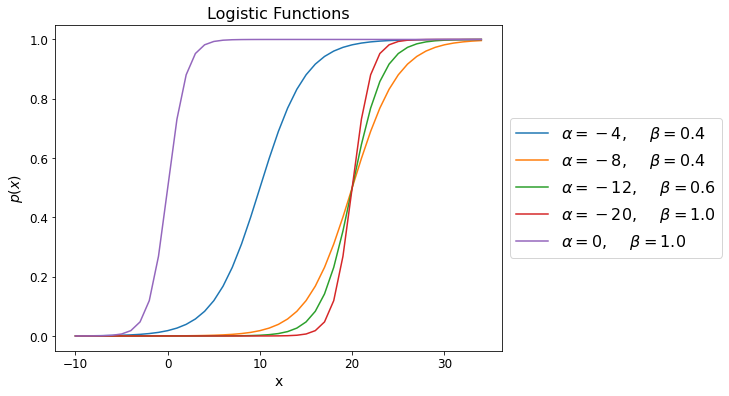

In [11]:
alphas = [-4, -8,-12,-20, 0]
betas = [0.4,0.4,0.6,1, 1]
x = np.arange(-10,35)
fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(111)

for i in range(len(alphas)):
    a = alphas[i]
    b = betas[i]
    y = np.exp(a+b*x)/(1+np.exp(a+b*x))
    ax.plot(x,y,label=r"$\alpha=%d,$    $\beta=%3.1f$" % (a,b))

ax.tick_params(labelsize=12)
ax.set_xlabel('x', fontsize = 14)
ax.set_ylabel('$p(x)$', fontsize = 14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
ax.set_title('Logistic Functions', fontsize = 16);

### Multi-Layer Perceptron (MLP) or Fully Connected Network (FCN)

<center>
    
<img src="figs/NN-figs/neural_net2.jpeg" width="75%">
    
</center>


From [cs231n](https://cs231n.github.io/convolutional-networks/)

Multiple artificial neurons can be acting on the same inputs, in what we call
a _layer_, and we can have more than one _layer_ until we produce one or more
outputs.

The example above shows a network with _3 inputs_, two layers of neurons, each
with 4 neurons, followed by one layer that produces a single value output.

E.g. a binary classifier.

## Computation Graph

The way we are going to differentiate more complex functions is to first build a "computation graph" to apply our operations on. We'll see that it breaks down the process into simple steps that easily scale to large networks.

It's the concept employed by TensorFlow and PyTorch, and in fact we'll follow PyTorch interface definition.

### Building the `Value` Class

To do that we will build a data wrapper as a `class` called `Value` and gradually build in on all the functionality we need to define a Multi-Layer Neural Network (a.k.a. Multi-Layer Perceptron) and train it.

First, the class has only a simple initialization method and a representation method.

In [12]:
# Value version 1
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

In [13]:
a = Value(4.0)
a

Value(data=4.0)

If you are not familiar with [python classes](https://docs.python.org/3/tutorial/classes.html), there are a few things to note here.
1. The property `self` is just a pointer to the object itself.
2. The `__init__` method is called when you initialize a class object
3. The `__repr__` method is how you represent the class object

### Implementing Addition

So the Value object doesn't do much yet except for taking a value and printing it. We'd also like to do things like addition and other operations with them, but...

In [14]:
a = Value(4.0)
b = Value(-3.0)

try:
    a+b 
except Exception as e:
    print("Uh oh!", e)
else:
    print("It worked!")

Uh oh! unsupported operand type(s) for +: 'Value' and 'Value'


When python tries to add two objects `a` and `b`, internally it will call
`a.__add__(b)`. So we have to add the `__add__()` method.

In [15]:
# Value version 2
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data)
        return out

In [16]:
a = Value(4.0)
b = Value(-3.0)

try:
    a+b
except Exception as e:
    print("Uh oh!", e)
else:
    print("It worked!")

It worked!


Which, as mentioned is equivalent to calling the `__add__` method on `a`.

In [17]:
a.__add__(b)

Value(data=1.0)

### Implementing More Operations

Similarly we can support multiplication and implement a ReLU function as well.

In [18]:
import numpy as np

# Value version 3
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

    def __add__(self, other): # self + other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other): # self * other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data)
        return out
    
    def relu(self):
        out = Value(np.maximum(0, self.data))
        return out

In [19]:
a = Value(4.0)
b = Value(-3.0)
c = Value(8.0)

d = a*b+c
d

Value(data=-4.0)

In [20]:
d.relu()

Value(data=0.0)

By the way, internally, python will call `__mul__` on `a`, then `__add__` on the temporary product object.

In [21]:
(a.__mul__(b)).__add__(c)

Value(data=-4.0)

### Child Nodes

In order to calculate the gradients, we will need to capture the computation graphs. To do that, we'll need to store pointers to the operands of each operation.

To start with, we'll accept a tuple of child nodes in the initializer and store that as a set in the object.

In [22]:
# Value version 4
class Value:
                        #    vvvvvvvvvvvv
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other)) # store tuple of children
        return out                        # ^^^^^^^^^^^^^
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other)) # store tuple of children
        return out                        # ^^^^^^^^^^^^^
    
    def relu(self):
        out = Value(np.maximum(0, self.data), (self,))
        return out                         #  ^^^^^^^

In [23]:
a = Value(4.0)
b = Value(-3.0)
c = Value(8.0)

d = a*b
e = d + c

We can now see the children of the operands that produced the output value by printing the `_prev` value. The name `_prev` might not be intuitive yet, but it will make more sense when we view these operations as a graph.

In [24]:
d._prev

{Value(data=-3.0), Value(data=4.0)}

In [25]:
e._prev

{Value(data=-12.0), Value(data=8.0)}

### Child Operations

Now we've recorded pointers to the child nodes. It would be helpful to also record the operator used.

We'll also add labels for convenience.

In [26]:
# Value version 5
class Value:
                                    #     vvvvvvv  vvvvvvvv
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op # store the operation that created this node
        self.label = label # label for the node

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)   
        out = Value(self.data + other.data, (self, other), '+') # store tuple of children
        return out                                      #  ^^^
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') # store tuple of children
        return out                                      #  ^^^
    
    def relu(self):                                 #  vvvvvv
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        return out

In [27]:
a = Value(4.0, label='a')
b = Value(-3.0, label='b')
c = Value(8.0, label='c')

d = a*b ; d.label = 'd'
e = d + c ; e.label = 'e'

In [28]:
d._prev, d._op, d.label

({Value(data=-3.0), Value(data=4.0)}, '*', 'd')

In [29]:
e._prev, e._op, e.label

({Value(data=-12.0), Value(data=8.0)}, '+', 'e')

### The Compute Graph

We now have enough information stored about the compute graph to visualize it.

These are two functions to walk the graph and build sets of all nodes and edges (`trace`) and then draw them as a
directed graph (`draw_dot`).

In [30]:
# draw_dot version 1
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and set of all edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this no de to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [31]:
a = Value(4.0, label='a')
b = Value(-3.0, label='b')
c = Value(8.0, label='c')

d = a*b ; d.label = 'd'
e = d + c ; e.label = 'e'

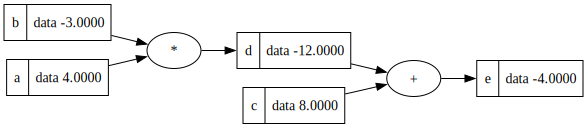

In [32]:
draw_dot(e)

Note that every value object becomes a node in the graph. The operators are also represented as a kind of fake node so they can be visualized too.

In [33]:
nodes, edges = trace(e)
print("Nodes: ", nodes)
print("Edges: ", edges)

Nodes:  {Value(data=-3.0), Value(data=-4.0), Value(data=4.0), Value(data=8.0), Value(data=-12.0)}
Edges:  {(Value(data=4.0), Value(data=-12.0)), (Value(data=8.0), Value(data=-4.0)), (Value(data=-12.0), Value(data=-4.0)), (Value(data=-3.0), Value(data=-12.0))}


Lets add one more operation, or stage in the compute graph.

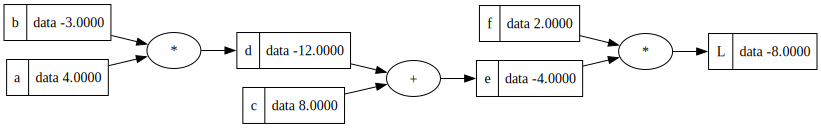

In [34]:
a = Value(4.0, label='a')
b = Value(-3.0, label='b')
c = Value(8.0, label='c')

d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(2.0, label='f')

L = e*f; L.label = 'L'

draw_dot(L)

### Recap

So far we've built a Value class and associated data structures to capture a computational graph and calculate the output based on the inputs and operations. We'll call this the __forward pass__.

But now, we're interested in calculating the gradients with respect to some of the parameters with respect to $L$. 

So next we'll update our Value class to capture the partial derivative at each node relative to L.

## Calculating Gradients


Add a gradient member variable, `grad`, to our class.

In [35]:
# Value version 6
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default to 0  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        self._prev = set(_children)
        self._op = _op # store the operation that created this node
        self.label = label # label for the node

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # store tuple of children
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') # store tuple of children
        return out
    
    def relu(self):
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        return out

And update `draw_dot()` to show `grad` in the node info.

In [36]:
# draw_dot version 2
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and set of all edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot        

And reinitialize and redraw...

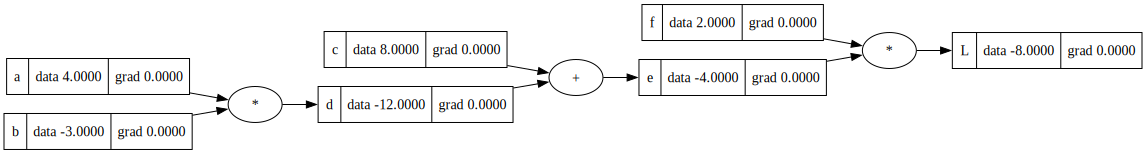

In [37]:
a = Value(4.0, label='a')
b = Value(-3.0, label='b')
c = Value(8.0, label='c')

d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(2.0, label='f')

L = e*f; L.label = 'L'

draw_dot(L)

### Manual Gradient Calculation

Before we start implementing backpropagation, it is helpful to manually calculate some gradients to better understand the procedure.

For the node $L$, we trivially calculate $\frac{dL}{dL} = 1$. 

From limit ratio perspective, 

$$ \frac{ (L+h) - L }{h} = \frac{h}{h} = 1$$

In [38]:
L.grad = 1.0

If we go backwards a step in the graph, we see that $L=e*f$, so we calculate

$$\frac{\partial{L}}{\partial{e}} = \frac{\partial}{\partial{e}} (e\times f) = f$$

and

$$\frac{\partial{L}}{\partial{f}} = \frac{\partial}{\partial{f}} (e\times f) = e.$$


In [39]:
e.grad = f.data

In [40]:
f.grad = e.data

> To summarize, the partial derivative w.r.t. to one operand of a simple product is simply the other operand.

And we can redraw the graph above again.

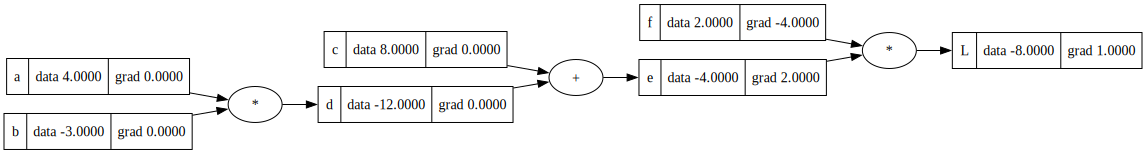

In [41]:
draw_dot(L)

In [42]:
# Try uncommenting `e += h` or `f += h` and calling `wiggle()` then `wiggle(1.0)`
# to see the influence of e or f on L
def wiggle(h = 0.0):
    a = Value(4.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(8.0, label='c')

    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e'
    # e += h
    f = Value(2.0, label='f')
    # f += h

    L = e*f; L.label = 'L'
    print(L)

In [43]:
wiggle()

Value(data=-8.0)


In [44]:
wiggle(1.0)

Value(data=-8.0)


### Propagating Back

Now we want to calculate

$$\frac{\partial{L}}{\partial{c}}$$

or put another way, we want to know how much $L$ wiggles if we wiggle $c$, or how $c$ influences $L$.

Looking at the graph again we see that $c$ influences $e$ and $e$ influences $L$, so we should be able see the ripple effect of $c$ on $L$.

$$ c \rightarrow e \rightarrow L $$

So $e = c + d$, and so we calculate

$$ \frac{\partial{e}}{\partial{c}} = \frac{\partial{}}{\partial{c}} (d + c) = 1$$

### Question

$$ c \rightarrow e \rightarrow L $$

So now we know $\partial{L}/\partial{e}$ and we also know $\partial{e}/\partial{c}$,

How do we get $\partial{L}/\partial{c}$?

### The Chain Rule

To paraphrase from the Wikipedia page on [Chain rule](https://en.wikipedia.org/wiki/Chain_rule), if a variable $L$ depends on the variable $e$, which itself depends on the variable $c$ (that is, $e$ and $L$ are dependent variables), then $L$ depends on $c$ as well, via the intermediate variable $e$. In this case, the chain rule is expressed as

$$\frac{\partial L}{\partial c} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial c},$$

and

$$ \left.\frac{\partial L}{\partial c}\right|_{c} = \left.\frac{\partial L}{\partial e}\right|_{e(c)}\cdot \left. \frac{\partial e}{\partial c}\right|_{c} ,$$

for indicating at which points the derivatives have to be evaluated.

Now since we've established that

$$ \frac{\partial{e}}{\partial{c}} = 1$$

then

$$\frac{dL}{dc} = \frac{dL}{de} \cdot 1.$$

So in the case of an operand in an addition operation, we just copy the gradient of the parent node.

Or put another way, 

> in the addition operator, we just route the parent gradient to the child.

In [45]:
d.grad = e.grad
c.grad = e.grad

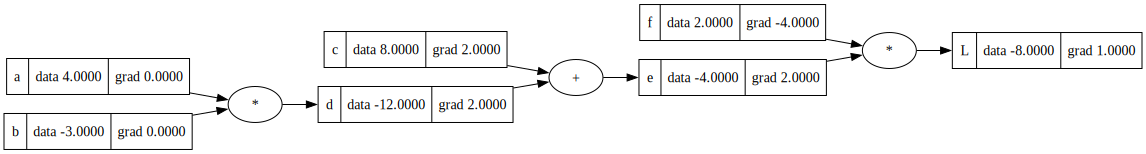

In [46]:
draw_dot(L)

In [47]:
# Try uncommenting `c += h` or `d += h` and calling `wiggle()` then `wiggle(1.0)`
# to see the influence of c or d on L
def wiggle(h = 0.0):
    a = Value(4.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(8.0, label='c')
    # c += h

    d = a*b; d.label = 'd'
    # d += h

    e = d + c; e.label = 'e'
    f = Value(2.0, label='f')

    L = e*f; L.label = 'L'
    print(L)

In [48]:
wiggle()

Value(data=-8.0)


In [49]:
wiggle(1.0)

Value(data=-8.0)


### Propagating Back Again

Now we want to calculate

$$ \frac{\partial{L}}{\partial{b}} \hspace{10pt} \textrm{and} \hspace{10pt} \frac{\partial{L}}{\partial{a}}$$

But we have

$$ \frac{\partial{L}}{\partial{d}}$$

and we know that

$$ \frac{\partial{d}}{\partial{b}} = \frac{\partial{}}{\partial{b}}(a\cdot b) = a$$

so again from the chain rule

$$\frac{\partial{L}}{\partial{b}} 
  = \frac{\partial{L}}{\partial{d}} \cdot \frac{\partial{d}}{\partial{b}}
  = \frac{\partial{L}}{\partial{d}} \cdot a$$


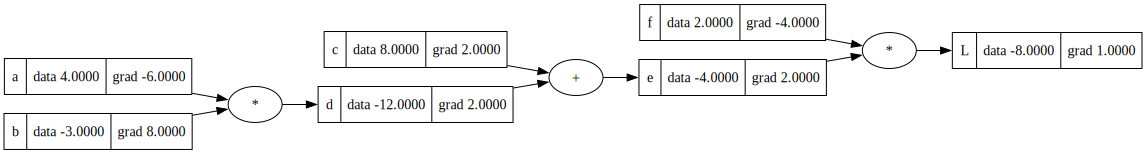

In [50]:
b.grad = a.data * d.grad
a.grad = b.data * d.grad
draw_dot(L)

In [51]:
# Try uncommenting `a += h` or `b += h` and calling `wiggle()` then `wiggle(1.0)`
# to see the influence of a or b on L
def wiggle(h = 0.0):
    a = Value(4.0, label='a')
    # a += h
    b = Value(-3.0, label='b')
    # b += h
    c = Value(8.0, label='c')

    d = a*b; d.label = 'd'

    e = d + c; e.label = 'e'
    f = Value(2.0, label='f')

    L = e*f; L.label = 'L'
    print(L)

In [52]:
wiggle()

Value(data=-8.0)


In [53]:
wiggle(1.0)

Value(data=-8.0)


### Recap

As you saw, we recursively went backwards through the computation graph and applied the local gradients to the gradients calculated so far to get the partial gradients. Put another we propagated this calculations backwards through the graph.

Of course, in practice, we will only need the gradients on the parameters, not the inputs, so we won't bother calculating them on inputs.

_That is the essence of Back Propagation._

## A Step in Optimization

Let's take a look at the graph again. Assume we want the value of L to _decrease_. We are free to change the values of the leaf nodes -- all the other nodes are derived from children and leaf nodes.

The leaf nodes are $a, b, c$ and $f$.

> Again, in practice we would only update the parameter leaf nodes, not the input leaf node, but we'll ignore that distinction temporarily for this exmaple.

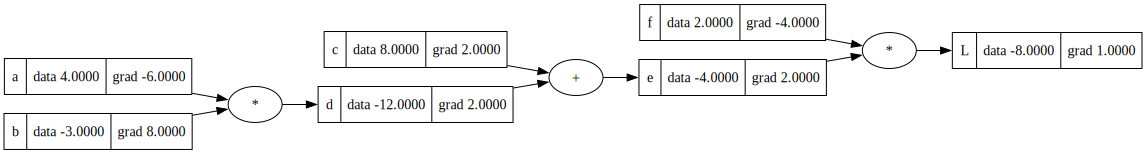

In [54]:
draw_dot(L)

Let's check the current value of L.

In [55]:
# remind ourselves what L is
print(L.data)

-8.0


As we showed before, we want to nudge each of those leaf nodes by the negative
of the gradient, multiplied by a step size, $\eta$.

$$ w_{n+1} = w_n - \eta * \frac{\partial{L}}{\partial{w_n}} $$

where $n$ is the iteration number.

In [56]:
# nudge all the leaf nodes along the negative direction of the gradient
step_size = 0.01    # also called eta above

a.data -= step_size * a.grad
b.data -= step_size * b.grad
c.data -= step_size * c.grad
f.data -= step_size * f.grad

# recompute the forward pass
d = a*b
e = d + c
L = e*f

print(L.data)

-9.230591999999998


## A Single Neuron

Let's now programmatically define a single neuron with
* two inputs
* two weights (1 for each input)
* a bias
* the ReLU activation function

Recall the neuron figure above.

In [57]:
# inputs x0, x1
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.relu(); o.label = 'o'

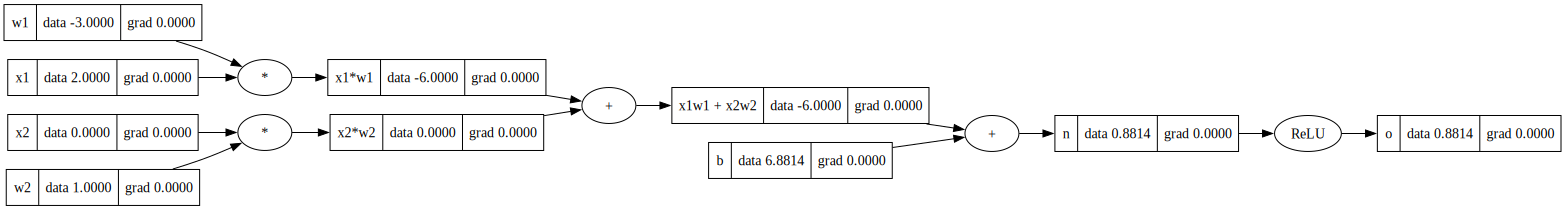

In [58]:
draw_dot(o)

The only new operation we've added is the ReLU, so let's take a quick look at how we 
differentiate the ReLU. 

Like before, for the output node, o:

$$ \frac{\partial o}{\partial o} = 1 $$

In [59]:
o.grad = 1.0

<!-- Credit: _Understanding Deep Learning_, Figure 7.6 -->
ReLU is technically not differentiable at 0, but practically we implement the
derivative as 0 when $ \le 0$ and 1 when $ 1 > 0 $

<center>

<img src="figs/NN-figs/Train2ReLUDeriv.svg" width="50%">

</center>

In [60]:
n.grad = (o.data > 0) * o.grad  # = 0 when o.data <= 0; = o.grad when o.data > 0

## Coding Backpropagation

Now we'll update our `Value` class once more to support the backward pass.

There's a
* private `_backward()` function _in each operator_ that implements the local
step of the chain rule, and
* a `backward()` function in the class that topologically sorts the graph and calls the operator `_backward()` function starting at the end of the graph and going _backward_.

In [61]:
# version 9
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default to 0, no impact on the output
        self._backward = lambda: None  # by default backward doesn't do anything
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

We redefined the class so we have to reinitialize the objects and run the operations again.

This constitutes the _forward pass_.

In [62]:
# inputs x0, x1
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
#b = Value(6.7, label='b')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.relu(); o.label = 'o'

So we've filled the data values for all the nodes, but haven't calculated the gradients.

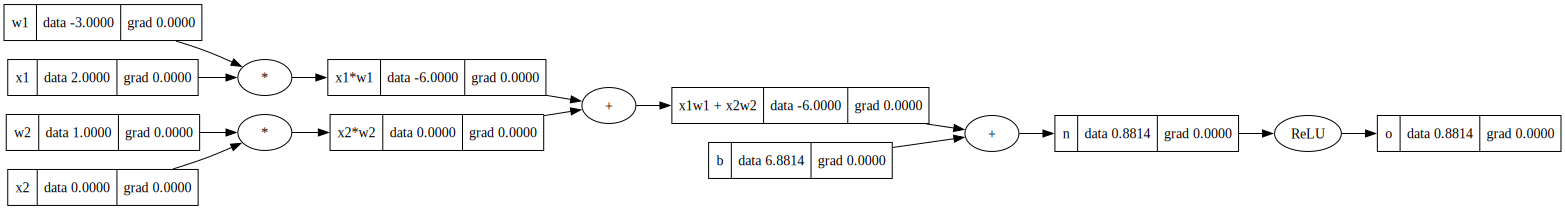

In [63]:
draw_dot(o)

Now, all we have to do is call the `backward()` method of the last node...

In [64]:
o.backward()

And voila! We have all the gradients!

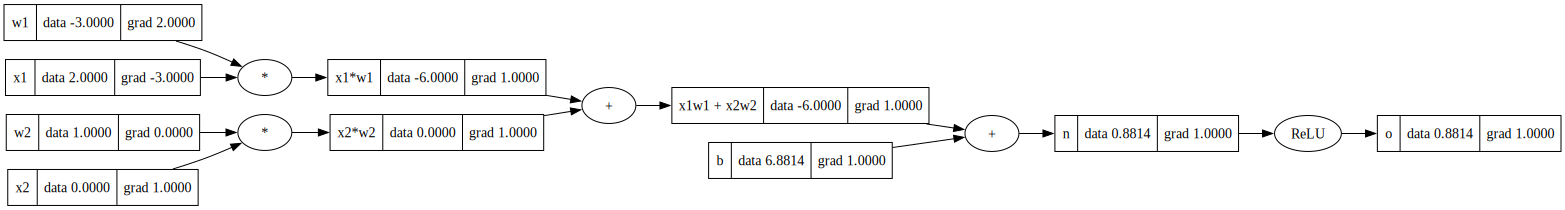

In [65]:
draw_dot(o)

### Accumulating the Gradients

The observant viewer will notice that we are accumulating the gradients.

That is to handle cases like where a `Value` object is on both sides of the operand like

In [66]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()

a

Value(data=3.0, grad=2.0)

If we didn't have the accumulation, then `a.grad = 1` instead.

Or the other case where a node goes to different operations.

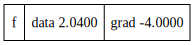

In [67]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b  ; d.label = 'd'
e = a + b   ; e.label = 'e'
  
draw_dot( f) 

You can see analytical verification of the above result in the note in the online book.

The risk now is that if you don't zero the gradients for the next update iteration, you will have incorrect gradients. 

> Always remember to zero the gradient in each iteration of the training loop!

```{note}

We can verify that the gradients are correct analytically.

To find the partial derivative $\frac{\partial f}{\partial a}$, we first need to define $f$ in terms of $a$ and $b$.

Given:
$$\begin{aligned}
d &= a \times b \\
e &= a + b      \\
f &= d \times e
\end{aligned}$$

Then $f$ can be expanded as:
$$\begin{aligned}
f &= (a \times b) \times (a + b) \\
f &= a^2 \times b + a \times b^2
\end{aligned}$$

Next, we find the partial derivative of $f$ with respect to $a$:
$$ \frac{\partial f}{\partial a} = 2a \times b + b^2 $$

Finally, we plug in the given values $a = -2.0$ and $b = 3.0$:
$$\begin{aligned}
\frac{\partial f}{\partial a} &= 2(-2.0) \times 3.0 + 3.0^2 \\
\frac{\partial f}{\partial a} &= -12.0 + 9.0                 \\
\frac{\partial f}{\partial a} &= -3.0
\end{aligned}$$

So the partial derivative $\frac{\partial f}{\partial a}$ for the value $a = -2.0$ is $-3.0$.

```

## Enhancements to `Value` Class

There are still some useful operations that `Value` doesn't support, so to be more
complete we have the final version of the `Value` class below.

We added:
* `__radd__` for when the `Value` object is the right operand of an add
* `__rmul__` for when the `Value` object is the right operand of a product 
* `__pow__` to support the ** operator
* plus some others you can see below

In [68]:
# version 9
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default to 0, no impact on the output
        self._backward = lambda: None  # by default backward doesn't do anything
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        """Adding support for ** operator, which we'll need for the 
        squared loss function"""
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data}, grad={self.grad})"

## Comparing to PyTorch

We're using a class implementation that resembles the PyTorch implementation, and in fact we can compare our implementation with PyTorch.

In [69]:
import torch

In [70]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.relu(n)

print(o.data.item())
o.backward()

print('---')
print('x2.grad', x2.grad.item())
print('w2.grad', w2.grad.item())
print('x1.grad', x1.grad.item())
print('w1.grad', w1.grad.item())

0.881373405456543
---
x2.grad 1.0
w2.grad 0.0
x1.grad -3.0
w1.grad 2.0


By default, tensors don't store gradients and so won't support backprop, so we explicitly set `requires_grad = True`.

## Neural Network Modules


Now we'll define some classes which help us build out a small neural network.

__Module__ -- A base class

__Neuron__ -- Implement a single linear or nonlinear neuron with `nin` inputs.

__Layer__ -- Implement a layer of network consisting of `nout` neurons, each taking `nin` inputs

__MLP__ -- A _Multi-Layer Perceptron_ that implements `len(nouts)` layers of neurons.

Each class can calculate a forward pass and enumerate all its parameters.

In [71]:
import random
# we assume that Value class is already defined

class Module:
    """Define a Neural Network Module base class """

    def zero_grad(self):
        """When we run in a training loop, we'll need to zero out all the gradients
        since they are defined to accumulate in the backwards passes."""
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    """Define a Neuron as a subclass of Module"""

    def __init__(self, nin, nonlin=True):
        """Randomly initialize a set of weights, one for each input, and initialize the bias to zero."""
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0.0)
        self.nonlin = nonlin

    def __call__(self, x):
        """Implement the forward pass of the neuron"""
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    """Define a Layer of Network as a subclass of Module"""

    def __init__(self, nin, nout, **kwargs):
        """Initialize nout Neurons, each with nin inputs"""
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        """Forward pass each neuron in the layer"""
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    """Define a Multi-Layer Perceptron"""

    def __init__(self, nin: int, nouts: list):
        """
        Initialize the Multi-Layer Perceptron, by initializing each layer
        then initializing each neuron of each layer.

        Parameters:
            nin: Number of inputs (int)
            nouts: A list of the number of neurons in each layer
        """
        sz = [nin] + nouts
        # self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

        # Create a list of layer objects for this MLP. All but the last layer
        # have ReLU activations. The last layer is linear.
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        """Forward pass through the MLP"""
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        """Recursively retrieve the parameters of the MLP"""
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [72]:
# help(Module)
# Module.__doc__
# help(Neuron)
# help(Layer)
# help(MLP)

### Initialize and Evaluate a Neuron

In [73]:
# 2 inputs
x = [2.0, 3.0]

# initialize neuron with 2 inputs
n = Neuron(2, nonlin=False)

# evaluate our neuron with our 2 inputs
n(x)

Value(data=1.817375555628387, grad=0.0)

In [74]:
n

LinearNeuron(2)

In [75]:
# list the 2 weights and the bias
n.parameters()

[Value(data=-0.09212327499555961, grad=0.0),
 Value(data=0.6672073685398354, grad=0.0),
 Value(data=0.0, grad=0.0)]

### Initialize and Evaluate a Layer of Neurons

In [76]:
# same 2 inputs again
x = [2.0, 3.0]

# Now initialize a layer of 3 neurons, each with 2 inputs
l = Layer(2, 3, nonlin=False)

# Evaluate our layer of neurons with the 2 inputs
l(x)

[Value(data=-0.5082721367249752, grad=0.0),
 Value(data=0.9659181620130699, grad=0.0),
 Value(data=-2.998155359520947, grad=0.0)]

In [77]:
l

Layer of [LinearNeuron(2), LinearNeuron(2), LinearNeuron(2)]

In [78]:
l.parameters()

[Value(data=-0.3560655702663116, grad=0.0),
 Value(data=0.067953001269216, grad=0.0),
 Value(data=0.0, grad=0.0),
 Value(data=-0.6838286986863324, grad=0.0),
 Value(data=0.777858519795245, grad=0.0),
 Value(data=0.0, grad=0.0),
 Value(data=-0.9507086525173045, grad=0.0),
 Value(data=-0.36557935149544596, grad=0.0),
 Value(data=0.0, grad=0.0)]

### Initialize and Evaluate an MLP

We'll instantiate an MLP like the picture below.

<center>
<img src="figs/NN-figs/neural_net2.jpeg" width="75%">
</center>


From [cs231n](https://cs231n.github.io/convolutional-networks/)

In [79]:
x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
m(x)

Value(data=1.7097339904870585, grad=0.0)

In [80]:
m

MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)], Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)], Layer of [LinearNeuron(4)]]

In [81]:
# m.parameters()

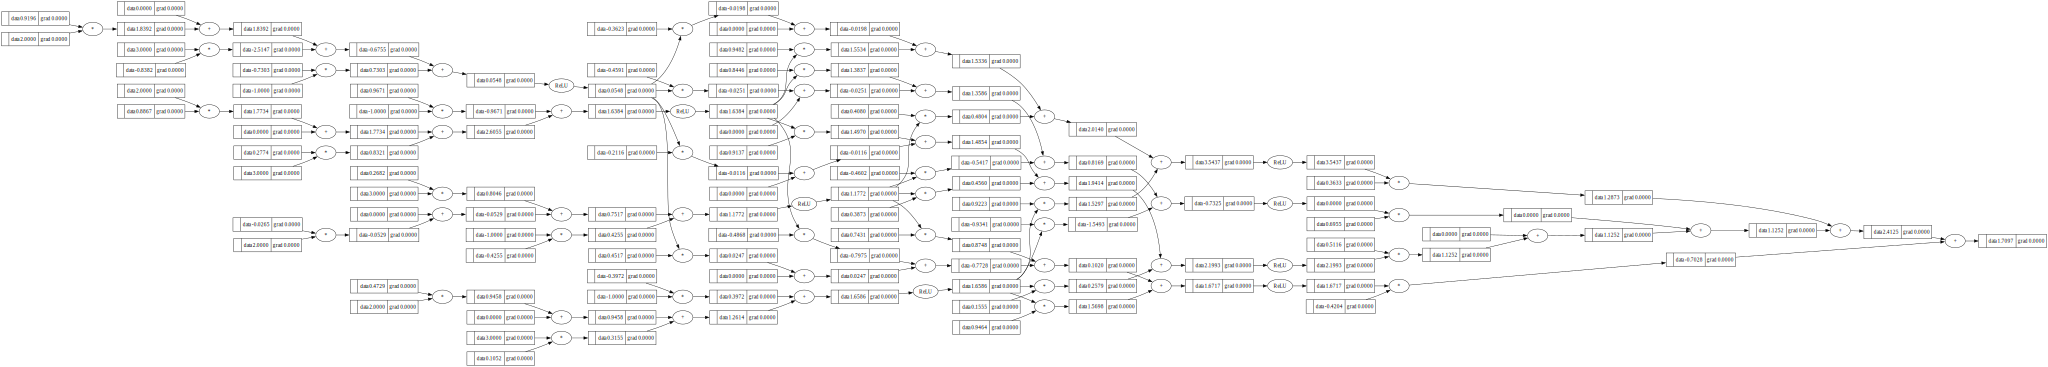

In [82]:
draw_dot(m(x))

## Training Loop
So after manually iterating, we put it all together in a training loop. We can repeatedly execute the next cell to continue training. 

In [83]:
# Define 4 different sets of inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# For each input set, we have a desired target value -- binary classification
# ys = [1.0, -1.0, -1.0, 1.0]
ys = [1.0, 0.0, 0.0, 1.0]

# Manually seed the Random Number Generator for Reproducibility
# You can comment the next line out see the variability
np.random.seed(1)

# Initialize an MLP with random weights
m = MLP(3, [4, 4, 1])

Final Loss:  0.7603378920266393


Text(0.5, 1.0, 'Loss Per Iteration')

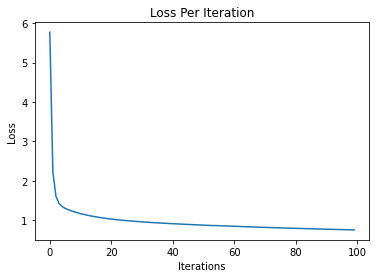

In [84]:
losses = []
niters = 100
step_size = 0.01

for k in range(niters):

    # Step 1: forward pass
    ypred = [m(x) for x in xs]
    
    # Step 2: Calculate the loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    losses.append(loss.data)

    # Step 3: Zero the gradients and run the backward pass
    m.zero_grad()
    loss.backward()

    # Step 4: Update parameters
    for p in m.parameters():
        p.data += -step_size * p.grad

    # print(k, loss.data)

print("Final Loss: ", loss.data)
    
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Loss Per Iteration")

In [85]:
ypred

[Value(data=0.5960312302549867, grad=-0.8079375394900266),
 Value(data=0.08679723870775247, grad=0.17359447741550493),
 Value(data=0.6640117396041365, grad=1.328023479208273),
 Value(data=0.6143813099473295, grad=-0.7712373801053409)]

## Build and Train the Equivalent MLP in PyTorch

In [86]:
import torch
from torch import nn
from torch.optim import SGD

# Manually seed the Random Number Generator for Reproducibility
# You can comment the next line out see the variability
torch.manual_seed(99)

# Step 1: Define the MLP model
class ptMLP(nn.Module):
    def __init__(self):
        super(ptMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = ptMLP()
print(model)

# Step 2: Define a loss function and an optimizer
criterion = nn.MSELoss(reduction='sum')
optimizer = SGD(model.parameters(), lr=0.01)

# Step 3: Create a tiny dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# we had to transpose ys for torch.tensor
ys_transpose = [[1.0], 
      [0.0], 
      [0.0], 
      [1.0]]

inputs = torch.tensor(xs)
outputs = torch.tensor(ys_transpose)

ptMLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)


Now run the training loop.

Final Loss: 0.06534022837877274


Text(0.5, 1.0, 'Loss Per Iteration')

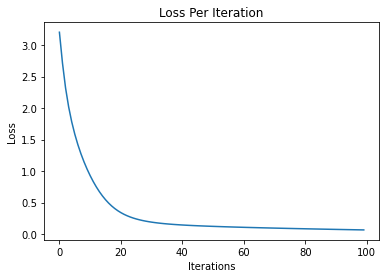

In [87]:
# Step 4: Write the training loop
losses = []
niters = 100

for epoch in range(niters):
    # Forward pass
    predictions = model(inputs)
    loss = criterion(predictions, outputs)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Zero the gradients
    optimizer.zero_grad()

    losses.append(loss.item())
    # print(f'Epoch {epoch+1}, Loss: {loss.item()}')

print(f'Final Loss: {loss.item()}')

plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Loss Per Iteration")

In [88]:
predictions

tensor([[1.1306],
        [0.0364],
        [0.0176],
        [0.7840]], grad_fn=<AddmmBackward0>)

## To Dig a Little Deeper

[PyTorch Quick Start Tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html)

[TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=30&dataset=gauss&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=4,4&seed=0.75152&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

## Summary

So today we...

* got a glimpse of the wide applications of neural networks
* revisited loss functions
* developed the notion of gradient descent first by intuition, then in the univariate case, then the multivariate case
* defined artificial neurons
* implemented a computation graph and visualization
* implemented the chain rule as backpropagation on the computation graph
* defined Neuron, Layer and MLP modules which completes are homegrown Neural Network Framework
* then trained a small MLP on a tiny dataset
* finally implemented the same in PyTorch